In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In this notebook I will explore the data, and see how well it can be used for prediction while relying on a stacked metamodel.

The given data is composed of features that represent age in years and the Big Five personality traits (each datapoint has ratings for openness, conscientiousness, extroversion, agreeableness, and neuroticism), and is labeled by overall personality labels that don't seem to be directly related to Big Five psychometrics: each datapoint is labeled as either dependable, extraverted, lively, responsible, or serious. It is unclear how these labels were created to begin with, and as we shall soon see these labels are at most weakly related to the Big Five ratings. Still, some limited predictions can ultimately be made.

But before we jump to showing the predictive capabilites of a stacking metamodel, let's get acquainted with the data. I'll start by concatenating train.csv and test.csv together so that the data can be first preprocessed and explored as a whole, although I'm not going to assume that these two datasets are similarly distributed (they aren't, which will result in some strange outcomes later on).



In [2]:
df_train = pd.read_csv('train.csv')
train_length = len(df_train)
df_test = pd.read_csv('test.csv')
df_train.rename(columns = {'Personality (Class label)':'Personality'}, inplace = True) 
df_test.rename(columns = {'Personality (class label)':'Personality'}, inplace = True) 
df = pd.concat([df_train, df_test])
df.head()

,Gender,Age,openness,neuroticism,conscientiousness,agreeableness,extraversion,Personality
0,Male,17,7,4,7,3,2,extraverted
1,Male,19,4,5,4,6,6,serious
2,Female,18,7,6,4,5,5,dependable
3,Female,22,5,6,7,4,3,extraverted
4,Female,19,7,4,6,5,4,lively


Before I preprocess anything, I'll do some exploration. I will draw a box-and-whiskers plot for each Big Five trait, to roughly see the distribution of each trait within each of the personality label categories.



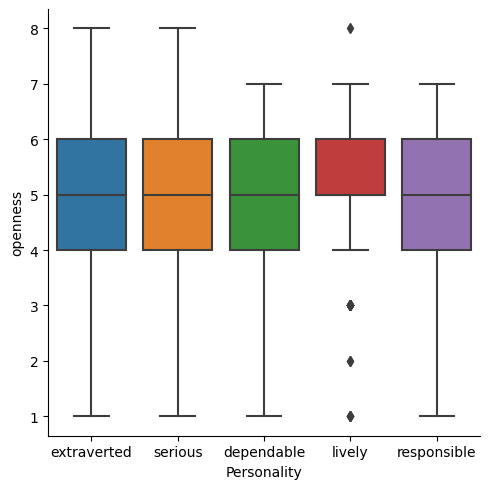

In [3]:
sns.catplot(x="Personality", y="openness", kind="box", data=df)


Each personality label has very similar distributions of 'openness', besides 'lively' which has a distribution which seems a bit more concentrated at above average values.



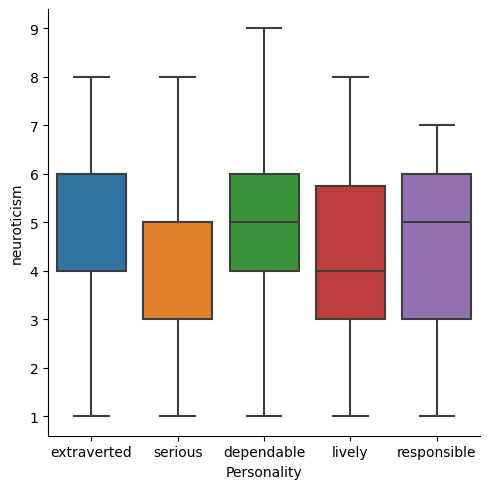

In [4]:
sns.catplot(x="Personality", y="neuroticism", kind="box", data=df)


'neuroticism' looks a bit more useful for us, in as much as it has somewhat different distributions within each personality label.



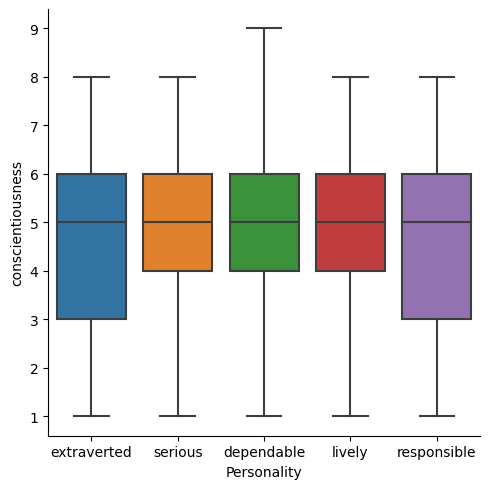

In [5]:
sns.catplot(x="Personality", y="conscientiousness", kind="box", data=df)

onscientiousness' is distributed quite similarly within each personality label, although the 'extraverted' and 'responsible' labels have more individuals with a below average rating.

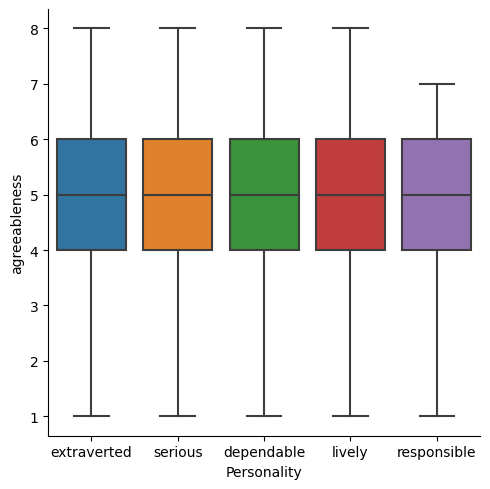

In [8]:
sns.catplot(x="Personality", y="agreeableness", kind="box", data=df)

'agreeableness' has basically identical distributions for each personality label, and is thus unlikely to be very useful when making predictions.

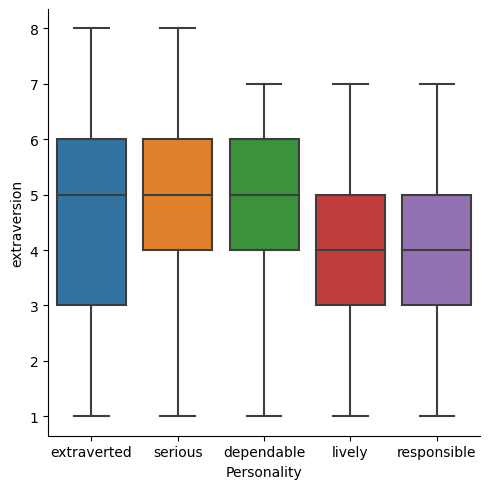

In [10]:
sns.catplot(x="Personality", y="extraversion", kind="box", data=df)

We can see that 'extraversion' has only somewhat different distributions across the personality labels, and a rough divide can be seen between some of the labels. Unlike 'agreeableness', it seems that 'extraversion' could be somewhat useful with regards to prediction.

So, from first glance, some Big Five traits seem potentially useful for prediction on their own ('neuroticism', 'extraversion'), some traits seem potentially quite useless on their own ('openness', 'agreeableness'), while 'conscientiousness' looks to be somewhere in between.

Before I do a bit more data exploration, some preprocessing is required. First I'll give 'Gender' and 'Personality' numerica

In [11]:
df['Gender'] = df['Gender'].map({'Male': 0,
                                 'Female': 1})

df['Personality'] = df['Personality'].map({'dependable': 0,
                                           'extraverted': 1,
                                           'lively': 2,
                                           'responsible': 3,
                                           'serious': 4})

Now I'll check for rows with null values:

In [12]:
df[df.isnull().sum(axis=1) > 0]


,Gender,Age,openness,neuroticism,conscientiousness,agreeableness,extraversion,Personality
449,NaN,21,2,5,6,1,5,4


Only one row with a null value, in 'Gender'. I'll quickly impute it, in a somewhat ad-hoc manner. I'll group our dataframe by 'Personality' and 'Age', and see what the mean age value is for 'serious' 21-year-olds:

In [13]:
df.groupby(by=['Personality', 'Age']).mean().loc[4]

,Gender,openness,neuroticism,conscientiousness,agreeableness,extraversion
Age,,,,,,
17,0.375000,4.916667,4.208333,5.041667,4.291667,5.375000
18,0.531250,5.000000,4.656250,5.109375,4.968750,4.843750
19,0.506024,4.710843,4.253012,4.433735,5.228916,5.156627
20,0.250000,4.975000,4.225000,5.200000,4.925000,4.825000
21,0.406250,4.575758,4.424242,5.030303,5.030303,5.030303
22,0.476190,5.142857,4.190476,4.619048,5.095238,4.476190
23,0.133333,4.466667,4.133333,4.933333,5.000000,5.000000
24,0.400000,4.866667,4.466667,5.133333,3.933333,5.666667
25,0.500000,5.125000,3.875000,5.375000,4.625000,5.250000


The mean is closer to 0 i.e. closer to the male numerical value. I'll therefore impute the missing value with 0.

In [14]:
df.at[449, 'Gender'] = 0

I'll now go back to do some more exploration: let's take a look at the correlation matrix of our data. This will allow us to see if there are any clear linear relationships between any of our values, and more importantly between any of our features and the label. We already have a rough idea from our box-and-whiskers plots that no Big Five trait seems to have a strong relationship with any of the personality labels, but looking at a correlation matrix may still be useful.

<Axes: >

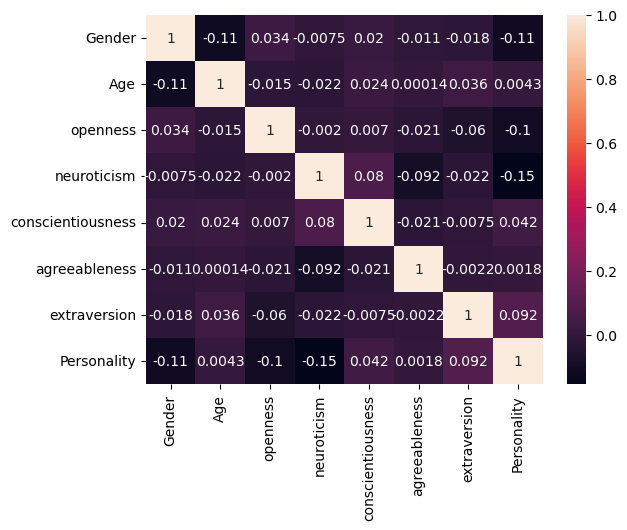

In [15]:
sns.heatmap(df.corr(), annot=True)


Alas, it's now clear that there aren't any strong linear relationships at play: the strongest correlations with regards to our label are with 'Gender' and 'neuroticism', and even those are quite weak. This does not discount the possibility of non-linear relationships that could allow a model to make good predictions, but it's not an encouraging start. Still, let us press on!

For our models to work well, we should make sure that our data isn't too skewed:

In [18]:
df.skew()


Gender              -0.093991
Age                  0.471614
openness            -0.638642
neuroticism         -0.412167
conscientiousness   -0.412381
agreeableness       -0.552094
extraversion        -0.359830
Personality         -0.140035
dtype: float64

'openness' and 'agreeableness' have a negative skew below -0.5, so it's probably a good idea to unskew these columns. I'll use a square root transformation over a reflection of these columns:



In [19]:
df['openness'] = np.sqrt(max(df['openness']+1) - df['openness'])
df['agreeableness'] = np.sqrt(max(df['agreeableness']+1) - df['agreeableness'])
df.skew()

Gender              -0.093991
Age                  0.471614
openness             0.234889
neuroticism         -0.412167
conscientiousness   -0.412381
agreeableness        0.107320
extraversion        -0.359830
Personality         -0.140035
dtype: float64

At this point, I will split the unified database back into the training and the test set, and then scale them separately:



In [21]:
df_train = df[:train_length]
df_test = df[train_length:]
Y, X = df_train.values[:,-1], df_train.values[:,:-1]
Y_test, X_test = df_test.values[:,-1], df_test.values[:,:-1]
X = RobustScaler().fit_transform(X)
X_test = RobustScaler().fit_transform(X_test)

hen we write machine learning models, we very often start with the i.i.d assumption: that is, we assume that our datapoints come from the same data-generating process, which also means that our training and test sets are assumed to be identically distributed. Let's see if this assumption holds in our case, by checking the distributions of personality labels in both our datasets:

In [23]:
df_train['Personality'].value_counts() / len(df_train)

4    0.227080
1    0.211566
0    0.194640
2    0.188999
3    0.177715
Name: Personality, dtype: float64

In [24]:
df_test['Personality'].value_counts() / len(df_test)


4    0.485714
1    0.244444
3    0.126984
2    0.076190
0    0.066667
Name: Personality, dtype: float64

As we can see, the training and test sets given to us seem to come from very different distributions. Whereas our training set is a bit imbalanced with regards to its personality labels, our test set is even more imbalanced: e.g., label 4, 'serious', makes up almost half of the labels in the test set, while labels 0 and 2 each make up less than ten percent.

This isn't a good situation: it means that we shouldn't expect any model trained on our training set to do very well on our test set. Still, let's continue and see what we can do.

First, I want to find the best hyperparameters for a number of different models. I'll start by defining the models and the parameter grids I want GridSearchCV to search through:



In [25]:
param_grids = {}
models = []

logistic = LogisticRegression()
models.append(logistic)
param_grids[logistic] = {'C':np.arange(0.01, 1, 0.01)}

svc = SVC()
models.append(svc)
param_grids[svc] = {'kernel':['poly','rbf'],
                    'C':np.arange(0.01, 1, 0.01)}

adaboost = AdaBoostClassifier()
models.append(adaboost)
param_grids[adaboost] = {'n_estimators':np.arange(10, 101, 10)}

knn = KNeighborsClassifier()
models.append(knn)
param_grids[knn] = {'n_neighbors':np.arange(2,11,1),
                    'weights':['uniform', 'distance'],
                    'p':np.arange(1,4,1)}

Now, I'll define a function that will be able to return the best models, and then use that function to get these best models and their scores:

In [26]:
def choose_hyperparameters(models, param_grids, X_train, Y_train):
    cv_models = {}
    scores = {}
    cv_with_scores = {}
    for model in models:
        label = str(type(model)).split('.')[-1].split("'")[0]
        gs = GridSearchCV(model, param_grid=param_grids[model])
        gs.fit(X_train, Y_train)
        cv_models[label] = gs
        scores[label] = gs.best_score_
        cv_with_scores[gs] = gs.best_score_
    return cv_models, scores, cv_with_scores

cv_models, scores, cv_with_scores = choose_hyperparameters(models, param_grids, X, Y)
scores

{'LogisticRegression': 0.23975626810508438,
 'SVC': 0.263779842173609,
 'AdaBoostClassifier': 0.2820497452801918,
 'KNeighborsClassifier': 0.272270502447308}

What we have here is a pretty bad situation: the best models we could find each have an accuracy of about 25 percent. That is, we might as well just choose our labels randomly, and get results that are about as accurate!

So, as our correlation heatmap has foretold, it seems that our datapoints don't seem to have any clear relationship with their accompanying labels. Can we try to make some lemonade from this quite sour lemon?

Maybe. Imagine you're an employer, and want to hire people who are specifically "responsible" or "dependable" more than anything else. Perhaps if you limit yourself to the following labels, you can achieve some sort of predictive capability by giving candidates Big 5 personality tests: either a candidate is responsible or dependable, OR he is not either of these. Let's relabel Y and Y_test accordingly, and fit some new models:



In [27]:
def relabel_personality(x):
    if x == 0 or x == 3:
        return 1
    else:
        return 0

relabel_personality_v = np.vectorize(relabel_personality)

Y = relabel_personality_v(Y)
Y_test = relabel_personality_v(Y_test)

cv_models, scores, cv_with_scores = choose_hyperparameters(models, param_grids, X, Y)
scores

{'LogisticRegression': 0.6276495854559985,
 'SVC': 0.6304764758765359,
 'AdaBoostClassifier': 0.6248326840475477,
 'KNeighborsClassifier': 0.6192088702427331}

These results are better than flipping a coin, but still quite mediocre. As we already understand, the relationship between the Big Five scores and the accompanying labels is very weak. Still, I'll define a few functions that will allow me to build a stacking metamodel, and then see how well such a metamodel does on our test set (a test set that has comes from a different distribution than our training set!).



In [28]:
def get_oof_predictions(model, X_train, Y_train, kf):
    m = len(X_train)
    oof_predictions = np.empty((m,))
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X[train_index], X[val_index] 
        Y_tr = Y[train_index]
        model.fit(X_tr, Y_tr)
        oof_predictions[val_index] = model.predict(X_val)
    return oof_predictions
        
def train_metamodel(metamodels, param_grids, models, X_train, Y_train, k):
    m = len(X_train)
    kf = KFold(n_splits=k)
    models_predictions = np.zeros(m)
    for model in models:
        oof_predictions = get_oof_predictions(model, X_train, Y_train, kf)
        models_predictions = np.column_stack((models_predictions, oof_predictions))
    models_predictions = models_predictions[:, 1:]
    cv_models, scores, cv_with_scores = choose_hyperparameters(metamodels, 
                                                               param_grids, 
                                                               models_predictions, 
                                                               Y_train)
    metamodel = max(cv_with_scores, key=cv_with_scores.get)
    return metamodel

def predict_with_models(models, X):
    m = len(X)
    models_predictions = np.zeros(m)
    for model in models:
        model_predictions = model.predict(X)
        models_predictions = np.column_stack((models_predictions, model_predictions))
    return models_predictions[:, 1:]

get_oof_predictions trains a model on all of a training set that is split into some number of cross validation sets, each time making predictions on the part of the training set that was not trained on. train_metamodel uses get_oof_predictions to get all of the out of fold ("oof") predictions for each model, and then chooses the best hyperparameters for the metamodel that uses all of the oof predictions to predict the labels. Finally, I will use predict_with_models to prepare all of the predictions that the metamodel requires to make a final prediction on the test set.

In [29]:
metamodels = models.copy()
models = list(cv_models.values())
metamodel = train_metamodel(metamodels, param_grids, models, X, Y, 5)
Y_pred = predict_with_models(models, X_test)
metamodel_test_score = metamodel.score(Y_pred, Y_test)
metamodel_test_score

0.8063492063492064

In [30]:
metamodel.best_score_

0.6304764758765359

Whereas the metamodel shows a slight improvement in prediction accuracy over even the best submodel when it comes to the training set (which is to be expected), it is surprisingly accurate when it comes to the test set (this is even more surprising due to the fact that the training and the test sets are differently distributed). This is likely due to an imbalance in the labels of both the training and the test set. Let's take a look:

In [31]:
np.unique(Y_test, return_counts = True)
np.unique(Y, return_counts = True)

(array([0, 1]), array([445, 264], dtype=int64))

Indeed, we can see an imbalance in both sets. The best that the metamodel learned to do was to predict 0 for almost every datapoint of the training set, and the same behavior applied to the test set ends up with an even higher accuracy:

In [32]:
np.unique(metamodel.predict(Y_pred), return_counts = True)


(array([0, 1]), array([313,   2], dtype=int64))

So while the test accuracy is high, were we to measure the F-score of our predictions (which also takes into account precision and recall), it wouldn't be terribly good at all. Alas, it seems that our data is simply not terribly suitable for good predictions (as we were afraid, from our preliminary exploration of the data), especially if it is divided into differently distributed training and test sets.

Another possible approach to the data that I have not shown in this notebook would be to balance the given training data, using an algorithm such as Synthetic Minority Oversampling Technique, before fitting the models and metamodel. Still, such an approach would not solve the problem of differently distributed training and test data, so I have chosen not to show it here.

SyntaxError: invalid syntax (3193540603.py, line 1)